In [1]:
import numpy as np
import cPickle
from zephyr.backend import MiniZephyrHD
from zephyr.middleware import TimeMachine, Helm2DViscoProblem, Helm2DSurvey
from scipy.ndimage import gaussian_filter

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 150

In [3]:
whichSource = 10

In [4]:
with open('seismic-ew.pickle', 'rb') as fp:
    u = cPickle.Unpickler(fp)
    systemConfig = u.load()
    
dims = (systemConfig['nz'], systemConfig['nx'])
extent=(
    systemConfig['xorig'],
    systemConfig['xorig'] + systemConfig['nx'] * systemConfig['dx'],
    systemConfig['zorig'],
    systemConfig['zorig'] + systemConfig['nz'] * systemConfig['dz'],
)
systemConfig.update({
    'freqs': np.linspace(2, 200, 100),
    'Disc': MiniZephyrHD,
    'nWorkers': 4,
})
systemConfig['geom']['src'] = systemConfig['geom']['src'][whichSource].reshape((1,2))

In [5]:
tm = TimeMachine(systemConfig)
systemConfig['sterms'] = tm.fSource(tm.keuper(40)).ravel()

In [6]:
survey = Helm2DSurvey(systemConfig)
problem = Helm2DViscoProblem(systemConfig)
problem.pair(survey)

In [7]:
uF = problem.fields()

In [8]:
u = uF[:]['u']

In [9]:
U = tm.dft(u.conj())

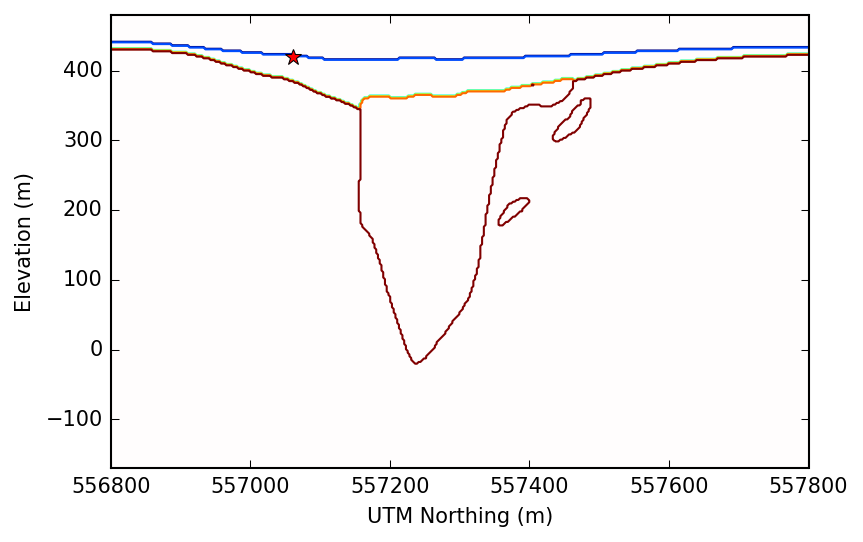

In [10]:
clim = 1e-2*abs(U).max()
sloc = systemConfig['geom']['src'][0]

plotOpts = {
    'cmap': cm.seismic,
    'vmin': -clim,
    'vmax': clim,
    'extent': extent,
}

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = plt.imshow(np.zeros(dims), **plotOpts)
plt.plot(sloc[0], sloc[1], 'r*', ms=8)
plt.contour(np.log(systemConfig['Q']), extent=extent)
plt.xlabel('UTM Northing (m)')
plt.ylabel('Elevation (m)')

def init():
    im.set_data(np.zeros(dims))
    return (im,)
def animate(i):
    d = np.flipud(U[:,i].reshape(dims).real)
    im.set_data(d)
    return (im,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tm.ns/2, interval=200, blit=True)

In [11]:
HTML(anim.to_html5_video())